# Data 참고 이미지

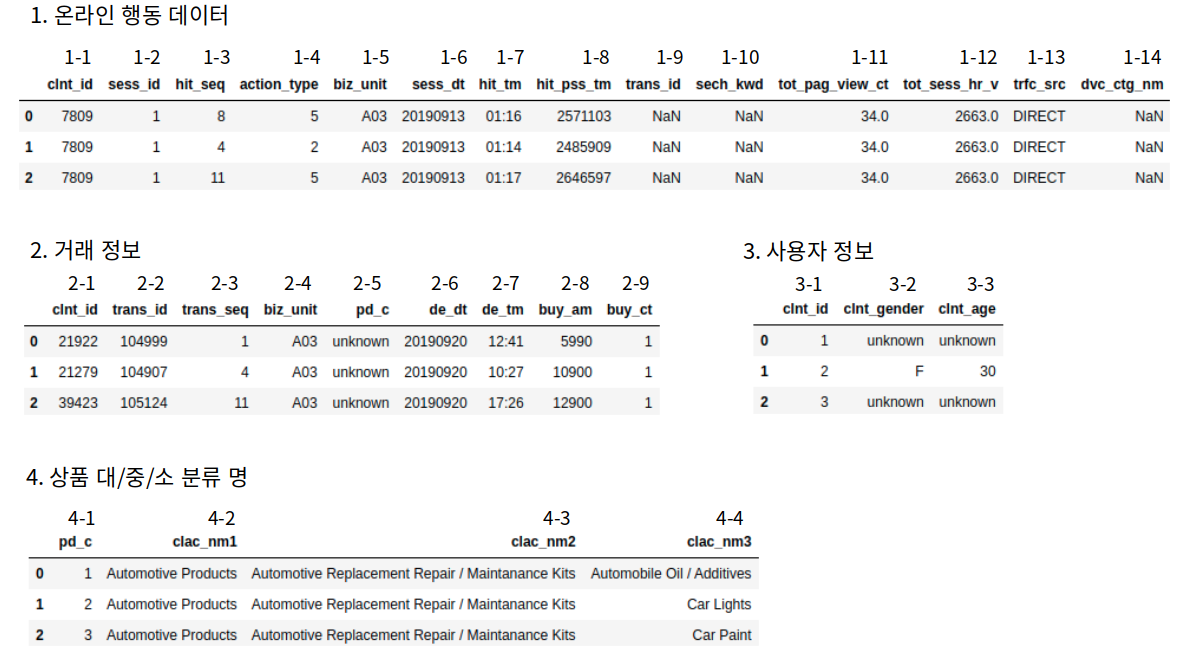

In [1]:
from IPython.display import Image

Image("raw_data_view_all.png")

# DATA EDA 분석 2 (2020.11.29(일))

    * 이번 EDA 목적
        * 1. 온라인 행동 데이터의 온라인 행동(1-4. action_type)이 어떤 상품(2-5. pd_c)에 대한 행동인지 확인
        
    * 현재 상황(문제점)
        * 현재 온라인 행동(1-4. 'action_type')과 상품코드(2-5. pd_c) column은 서로 다른 csv파일에 저장되어,  
          각 데이터에서 온라인 행동이 어떤 상품에 대하여 이루어진 것인지 알 수 없음
          
    * 확인 방안
        1. 1. 온라인 행동 데이터의 'sech_kwd'(1-10)를 가지고 행동 상품 유추
        2. 'trans_id'(1-9, 2-2)를 활용하여 1. 온라인 행동 데이터와 2. 거래 정보 데이터 merge

### 확인 방안 1. 1. 온라인 행동 데이터의 'sech_kwd'(1-10)를 가지고 행동 상품 유추

    * 최종 수행 방안(진행 중)
        * 검색 키워드(1-10. 'sech_kwd')를 파파고를 활용하여 한글 => 영어로 변환 한 후,  
          상품 소분류명(4-4. clac_nm3)과 유사한 키워드를 찾아 상품 소분류 코드(4-1, 2-5, pd_c)와 매칭하여,
          온라인 행동(1-4. action_type)이 어떤 상품(2-5. pd_c)에 대한 행동인지 확인

    * 현 상황 문제점
        *  'sech_kwd'(1-10)는 온라인 행동 'action_type' == 0. 검색인 데이터에 대하여만 존재함
            => 'sech_kwd'(1-10) 값을 NaN으로 가지는 온라인 행동 'action_type' == 1~7 에 대하여, 'sech_kwd' 값을 가지 데이터와,  
                같은 고객ID(clnt_id), 세션ID(sess_id), biz_unit을 가지고 데이터간 조회 시간 차이가 1시간 이내인 경우,  
                같은 키워드에 대한 데이터로 판단하고 행동 키워드('act_kwd')를 붙임 => In[14] cell 참조

* 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

 * 데이터 불러오기

In [3]:
# 1. 온라인 행동 데이터
raw_data1_Online_Act = pd.read_csv('./data/data1_Online_Act.csv')

# 2. 거래 정보 데이터
raw_data2_Trade_Inform = pd.read_csv('./data/data2_Trade_Inform.csv')

# 3. 사용자 demo 정보(나이, 성별)
raw_data3_Demog = pd.read_csv('./data/data3_Demog.csv')

# 4. 상품 대중소 분류 정보
raw_data4_Item_Class = pd.read_csv('./data/data4_Item_Class.csv')

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1. 온라인 행동 데이터 확인

In [4]:
raw_data1_Online_Act.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


* 1-1. clnt_id : 고객 고유 식별 ID
* 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID
* 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호
* 1-4. action_type : 온라인 행동 유형
 (0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 / 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션)
* 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드
* 1-6. sess_dt : 세션 일자(년월일)
* 1-7. hit_tm : 조회 시각(HH:MM)
* 1-8. hit_pss_tm : 조회 경과시간(세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정)
* 1-9. Trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
* 1-10. sech_kwd : 고객이 검색한 키워드
* 1-11. tot_pag_view_ct : 총 페이지 조회 건수(세션 내에 총 페이지(화면) 뷰 수)
* 1-12. tot_sess_hr_v : 총 세션 시간 값
* 1-13. trfc_src : 유입 채널
 (DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown)
* 1-14. dvc_ctg_nm : 기기 유형 (mobile_web / mobile_app / PC)

In [5]:
raw_data1_Online_Act.shape

(3196362, 14)

 * 행 수(데이터 갯수) : 319만 개
 * 열 수(데이터 종류) : 14개

* 데이터를 - clnt_id -> sess_id -> sess_dt(일자) -> hit_tm(시분) -> hit_pss_tm(밀리초) 순으로 정렬(시간순 정렬)
    * 같은 고객ID와 세션_id를 가지고, 같은 일자 비슷한 시점의 온라인 행동은 같은 품목에 의해서 수행되었을 것이다 가정

In [6]:
raw1_sorted_time = raw_data1_Online_Act.sort_values(by = ['clnt_id', 'sess_id', 'sess_dt', 'hit_tm', 'hit_pss_tm'], axis=0)
raw1_sorted_time.head(50)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3102890,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
3136925,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
3065714,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3091872,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
3142610,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app
3084082,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app
3136926,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app
3123796,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app
3001880,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app
3142609,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app


 * index_reset
     * 기존 인덱스를 지우고, 현재 순서에 맞는 index 생성

In [7]:
raw1_sorted_time = raw1_sorted_time.reset_index()

In [8]:
# 기존 인덱스가 reset_index() 함수로 인해 columns으로 생성 된 것을 삭제
raw1_sorted_time = raw1_sorted_time.drop(['index'], axis=1)

In [9]:
raw1_sorted_time.head(5)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app


In [10]:
# 뒤에 for문이 시간이 오래 걸리므로 시간 확인용 라이브러리 추가
from tqdm import tqdm

 * 1000개 data만 예시로 'act_kwd' 열 추가

In [26]:
# # test 용 코드로 1000개 data만 미리 돌려봄
# # 검색 키워드 data를 이용해서 온라인 행동에 대한 키워드 coloums을 새롭게 만듦
# raw1_sorted_time['act_kwd'] = raw1_sorted_time['sech_kwd']

# for s in tqdm(range(1000)):
    
#     # data row에 '검색 키워드'가 NaN이면
#     if type(raw1_sorted_time['sech_kwd'].loc[s]) == str:
#         # 아무것도 안함
#         pass
        
#     elif (raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
#           and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
#           and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
#           and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 3600000  # 시간 간격이 1시간 이내이거나
#           or ((raw1_sorted_time['sess_dt'][s] - raw1_sorted_time['sess_dt'][s-1] == 1)                  # 이전 거래와 일자가 하루 차이나고,
#           and ((raw1_sorted_time['hit_tm'][s-1][0:2] == '23') and (int(raw1_sorted_time['hit_tm'][s-1][3]) >= 3)) # 이전 거래 시간이 23:30 이후이고,
#           and (raw1_sorted_time['hit_pss_tm'][s] <= 1800000))):                                         # 다음 거래가 세션 시작부터 30분 이내 일 때,
#         raw1_sorted_time['act_kwd'][s] = raw1_sorted_time['act_kwd'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-26-47bd8f8518ea>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw1_sorted_time['act_kwd'][s] = raw1_sorted_time['act_kwd'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.
100%|██████████| 1000/1000 [00:10<00:00, 98.15it/s]


 * 'act_kwd' 열 추가
 * 아래 코드는 8시간 이상 소요되는 것에 주의!!!

In [29]:
# 8시간 이상 소요됨 
# 검색 키워드 data를 이용해서 온라인 행동에 대한 키워드 coloums을 새롭게 만듦
raw1_sorted_time['act_kwd'] = raw1_sorted_time['sech_kwd']

for s in tqdm(range(len(raw1_sorted_time['sech_kwd']))):
    
    # data row에 '검색 키워드'가 NaN이면
    if type(raw1_sorted_time['sech_kwd'].loc[s]) == str:
        # 아무것도 안함
        pass
        
    elif (raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
          and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
          and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
          and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 3600000  # 시간 간격이 1시간 이내이거나
          or ((raw1_sorted_time['sess_dt'][s] - raw1_sorted_time['sess_dt'][s-1] == 1)                  # 이전 거래와 일자가 하루 차이나고,
          and ((raw1_sorted_time['hit_tm'][s-1][0:2] == '23') and (int(raw1_sorted_time['hit_tm'][s-1][3]) >= 3)) # 이전 거래 시간이 23:30 이후이고,
          and (raw1_sorted_time['hit_pss_tm'][s] <= 1800000))):                                         # 다음 거래가 세션 시작부터 30분 이내 일 때,
        raw1_sorted_time['act_kwd'][s] = raw1_sorted_time['act_kwd'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.

  0%|          | 0/3196362 [00:00<?, ?it/s]<ipython-input-29-de7d868c259e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw1_sorted_time['act_kwd'][s] = raw1_sorted_time['act_kwd'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.
100%|██████████| 3196362/3196362 [8:17:54<00:00, 106.99it/s]  


In [30]:
# 파일 저장
raw1_sorted_time.to_csv("raw1_add_act_kwd.csv", mode='w')

 * act_kwd_추가한 파일 불러오기

In [11]:
# 저장한 파일 불러오기
raw1_sorted_time = pd.read_csv("raw1_add_act_kwd.csv")
raw1_sorted_time = raw1_sorted_time.drop("Unnamed: 0", axis=1)

 * 데이터 확인
     * 기존에 'sech_kwd'값을 NaN으로 갖던 데이터 들에 대하여 'act_kwd'열에 키워드가 추가된 것을 확인

In [12]:
# 데이터 확인
raw1_sorted_time[670:700]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
670,17,3,35,0,A03,20190731,00:26,1524129,NaN,놀부부대찌개,87.0,4012.0,DIRECT,NaN,놀부부대찌개
671,17,3,36,5,A03,20190731,00:27,1591307,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
672,17,3,37,3,A03,20190731,00:29,1687126,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
673,17,3,38,5,A03,20190731,00:30,1768475,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
674,17,3,39,5,A03,20190731,00:30,1781597,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
675,17,3,40,5,A03,20190731,00:31,1803463,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
676,17,3,41,1,A03,20190731,00:33,1976995,NaN,NaN,87.0,4012.0,DIRECT,NaN,놀부부대찌개
677,17,3,42,0,A03,20190731,00:38,2261886,NaN,라이너,87.0,4012.0,DIRECT,NaN,라이너
678,17,3,43,0,A03,20190731,00:43,2553388,NaN,식빵,87.0,4012.0,DIRECT,NaN,식빵
679,17,3,44,3,A03,20190731,00:43,2561452,NaN,NaN,87.0,4012.0,DIRECT,NaN,식빵


 * 새로 추가한 'act_kwd'(행동 키워드)에 대한 EDA

In [13]:
raw1_sorted_time['act_kwd'].value_counts()

우유                      40591
두부                      22693
계란                      20821
생수                      20073
라면                      11342
                        ...  
해잔들고추장                      1
산타 크루즈 컨버터블                 1
데일리슈 리어드 스트랩 샌들 4cm굽        1
코멘후라이펜                      1
셔링밴딩팬츠                      1
Name: act_kwd, Length: 101952, dtype: int64

In [14]:
raw1_sorted_time['act_kwd'].value_counts().sum()

1805304

In [15]:
raw1_sorted_time['sech_kwd'].value_counts().sum()

651638

 * 기존 action_type = 0('검색')에만 있던 키워드 65만개에서 180만개로 키워드 증가

### 검색 키워드(1-10. sech_kwd)의 검색 횟수 별 키워드 갯수 확인

In [16]:
sech_kwd = raw_data1_Online_Act['sech_kwd'].value_counts()
sech_kwd

우유             8985
두부             5210
계란             5039
생수             4283
수박             2694
               ... 
아레나 쥬니어           1
양ㅅㅇ추              1
헤라 모공수축           1
디디에두보 9월탄생석       1
여름 플레어 스커트        1
Name: sech_kwd, Length: 101952, dtype: int64

 * 검색 횟수 별 키워드 분석
     * 검색 키워드 총 갯수 : 101952개
     * 1회 검색된 키워드 : 53320개
     * 2회 검색된 키워드 : 18732개
     * 3회 검색된 키워드 : 8172개
     * 4회 검색된 키워드 : 4718개
     * 5회 검색된 키워드 : 2910개
     * 6회 검색된 키워드 : 2065개
     * 7회 검색된 키워드 : 1608개
     * 8회 검색된 키워드 : 1188개
     * 9회 검색된 키워드 : 899개
     * 10회 이상 검색된 키워드 : 8340개

In [17]:
sech_kwd[sech_kwd == 1]

가스점화기                          1
오사ㅉ                            1
비스비바 지프                        1
여성 노브러쉬 울트라 앵클스키니(YH1D9048)    1
파인애플새우볶음밥                      1
                              ..
아레나 쥬니어                        1
양ㅅㅇ추                           1
헤라 모공수축                        1
디디에두보 9월탄생석                    1
여름 플레어 스커트                     1
Name: sech_kwd, Length: 53320, dtype: int64

In [18]:
sech_kwd[sech_kwd == 2]

CMM885           2
배럴 래쉬가드 여성 상의    2
여행용칫솔            2
온앤온 원버튼컬러자켓      2
애플 충전기           2
                ..
미인고추             2
미를               2
한우찌게거리           2
358099219        2
부페               2
Name: sech_kwd, Length: 18732, dtype: int64

In [19]:
sech_kwd[sech_kwd == 3]

롯데팜앤홈       3
cj맥스봉       3
하겐다즈 멀티바    3
자넬라토 니나     3
베베드피노수트     3
           ..
김하진갈비탕      3
무설탕         3
티렌 원피스      3
에픽여성드라이버    3
숄더클러치       3
Name: sech_kwd, Length: 8172, dtype: int64

In [20]:
sech_kwd[sech_kwd == 4]

센텔리안24       4
라포프블라우스      4
우븐팬츠         4
엘지 식기세척기     4
필로시코스        4
            ..
아끼바레         4
리바트싱글침대      4
여성스트라이프셔츠    4
꿈비 침대        4
시그니아         4
Name: sech_kwd, Length: 4718, dtype: int64

In [21]:
sech_kwd[sech_kwd == 5]

에블린 어나더미          5
알파카               5
수면공감              5
세탁바구니             5
발뮤다토스터            5
                 ..
행남자기              5
햇반 잡곡             5
아토세이프 액체세제        5
BR2PT014L0        5
햇사레복숭아 백도4.5kg    5
Name: sech_kwd, Length: 2910, dtype: int64

In [22]:
sech_kwd[sech_kwd == 6]

핑크립스틱           6
프리미엄파인애플슬라이스    6
m20             6
소쿠리             6
업체택배상품          6
               ..
s831s32 실버      6
맥 블러셔           6
생수500ml아이시스     6
뉴트리디데이 쏘팔메토     6
자일리톨 껌          6
Name: sech_kwd, Length: 2065, dtype: int64

In [23]:
sech_kwd[sech_kwd == 7]

나눔용기       7
빈폴조끼       7
쁘띠첼 푸딩     7
부침용두부      7
바른어묵       7
          ..
스미글        7
디노바시 4부    7
간장 새우장     7
홈스타 주방     7
아쿠아삭스      7
Name: sech_kwd, Length: 1608, dtype: int64

In [24]:
sech_kwd[sech_kwd == 8]

헤라블랙파운데이션    8
폴딩박스         8
바섯           8
얇은피만두        8
미장센 트리트먼트    8
            ..
가브리살         8
생선그릴         8
하바           8
먼싱웨어         8
샤넬바디오일       8
Name: sech_kwd, Length: 1188, dtype: int64

In [25]:
sech_kwd[sech_kwd == 9]

염장미역줄기            9
호주산 찜갈비           9
미니골드 팔찌           9
빅토리녹스 스위스아미나이프    9
나이키 후드집업          9
                 ..
다우니섬유유연제          9
452845918         9
오뚜기짜장             9
모짜렐라치즈 1kg        9
코디화장지             9
Name: sech_kwd, Length: 899, dtype: int64

In [26]:
sech_kwd[sech_kwd >= 10]

우유            8985
두부            5210
계란            5039
생수            4283
수박            2694
              ... 
아기세제            10
자유공간 커튼봉 8      10
려염색약            10
A4              10
나이키 점프맨         10
Name: sech_kwd, Length: 8340, dtype: int64

### 확인 방안 2. trans_id를 활용하여 1. 온라인 행동 데이터와 2. 거래 정보 데이터 merge

    * 최종 수행 방안(진행 중)
        * 1. 온라인 행동 데이터와 2. 거래정보 데이터를 merge 하여,  
          온라인 행동(1-4. action_type)과 상품 소분류 코드(2-5. pd_c) 매칭

    * 현 상황 문제점
        * 'trans_id'는 온라인 행동(1-4. action_type) 6. 구매 완료, 7. 구매 환불 2가지 행동에 대해서만 존재 => In[29] cell 참조
            => 데이터 merge 후, 'trans_id'가 NaN인 다른 온라인 행동 데이터(0. 검색, 1.제품 목록 2.세부정보 3, 4, 5)가   
               'trans_id' 값이 있는 데이터와  같은 고객ID(clnt_id), 세션ID(sess_id), biz_unit을 가지고,
                데이터간 조회 시간 차이가 1시간 이내인 경우, 같은 상품에 대한 온라인 행동으로 예측  
               
        *  1. 온라인 행동 데이터와 2. 거래정보 데이터 merge를 위한 key columns으로 활용할 만한 열인 'trans_id'는  
           중복 데이터를 가지므로 온전한 key 역할을 하기 어려움.
           * 같은 trans_id 값에 여러 개의 온라인 행동(1-4. action_type) 데이터 존재
           * 같은 trans_id 값에 여러 개의 상품 소분류 코드(2-5. pd_c) 데이터 존재
               => 중복이 없는 trans_id만 사용하여 merge 활용
           

 * 참고사항 1
     * 1. 온라인 행동 데이터 내에 거래ID(1-9. 'trans_id')의 값은 action_type 6(구매완료), 7(구매 환불)에 대하여만 존재함

In [27]:
raw1_sorted_time['action_type'][raw1_sorted_time['trans_id'].isna() == False].value_counts()

6    51313
7     5676
Name: action_type, dtype: int64

 * 데이터 결합 전 확인 사항
     * merge 전 각 DF의 'trans_id'에 대한 중복 확인

In [28]:
raw1_sorted_time['trans_id'].value_counts()

71558.0     62
57672.0     52
104537.0    48
103669.0    31
99521.0     28
            ..
87919.0      1
87918.0      1
87917.0      1
87916.0      1
38728.0      1
Name: trans_id, Length: 50997, dtype: int64

In [29]:
raw_data2_Trade_Inform['trans_id'].value_counts()

132554    105
51589     100
102723     72
132637     72
137451     65
         ... 
122815      1
4720        1
64109       1
114929      1
102596      1
Name: trans_id, Length: 116440, dtype: int64

 * 1. 온라인 행동 데이터 중복 데이터 내용 확인
      * 같은 거래ID(1-9. 'trans_id') 값을 가졌지만, sess_id, action_type, 날짜, 시간 등이 다를 수 있다는 것을 확인

In [30]:
raw1_sorted_time[raw1_sorted_time['trans_id'] == 71558].head(50)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
132316,3689,2,4,6,A02,20190808,07:47,373016,71558.0,NaN,11.0,393.0,unknown,mobile_app,NaN
132319,3689,4,1,7,A02,20190816,00:19,85501,71558.0,NaN,11.0,618.0,unknown,mobile_app,NaN
132321,3689,4,3,7,A02,20190816,00:28,597372,71558.0,NaN,11.0,618.0,unknown,mobile_app,NaN
132322,3689,5,1,7,A02,20190816,19:30,0,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132323,3689,5,2,7,A02,20190816,19:30,2001,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132324,3689,5,3,7,A02,20190816,19:32,129348,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132325,3689,5,4,7,A02,20190816,19:33,180079,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132326,3689,5,5,7,A02,20190816,19:33,182139,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132327,3689,5,6,7,A02,20190816,19:33,183888,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN
132328,3689,5,7,7,A02,20190816,19:33,184695,71558.0,NaN,17.0,225.0,unknown,mobile_app,NaN


 * 2. 거래 정보 데이터 중복 데이터 내용 확인
     * 같은 거래ID(trans_id)를 가졌어도 소분류 상품(pd_c)은 서로 다른 복수 개 일 수 있다는 것을 확인
       => 거래ID(trans_id)로 온라인 데이터와 거래정보 데이터를 병합하여도 각 온라인 행동에 대한 소분류 품목을 알수 없음을 확인

In [31]:
raw_data2_Trade_Inform[raw_data2_Trade_Inform['trans_id'] == 132554].head(50)

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
215844,54272,132554,54,B01,1571,20190706,11:41,1380,1
215854,54272,132554,9,B01,0172,20190706,11:41,4280,1
215857,54272,132554,27,B01,0545,20190706,11:41,6900,1
216092,54272,132554,65,B01,1185,20190706,11:41,4240,1
262383,54272,132554,50,B01,1243,20190706,11:41,3200,1
262384,54272,132554,51,B01,1247,20190706,11:41,3200,1
262385,54272,132554,4,B01,0114,20190706,11:41,6400,1
262387,54272,132554,28,B01,1393,20190706,11:41,8400,2
262390,54272,132554,1,B01,0114,20190706,11:41,5880,1
262391,54272,132554,2,B01,0109,20190706,11:41,7980,2


 * 중복 없이 trans_id가 유일한 데이터 확인

In [32]:
raw1_transid = raw1_sorted_time['trans_id'].value_counts()
raw1_transid[raw1_transid == 1]

64846.0    1
64057.0    1
64019.0    1
63787.0    1
64822.0    1
          ..
87919.0    1
87918.0    1
87917.0    1
87916.0    1
38728.0    1
Name: trans_id, Length: 47040, dtype: int64

In [33]:
raw2_transid = raw_data2_Trade_Inform['trans_id'].value_counts()
raw2_transid[raw2_transid == 1]

48552     1
102911    1
64765     1
140925    1
142460    1
         ..
122815    1
4720      1
64109     1
114929    1
102596    1
Name: trans_id, Length: 35747, dtype: int64

In [34]:
# 1. 온라인 행동 정보 데이터에서 'trans_id'가 유일하게 1개인 'trans_id'값을 set(집합) 형태로 반환
raw1_transid_only_one = raw1_transid[raw1_transid == 1]
raw1_transid_only_one = raw1_transid_only_one.reset_index()['index']
raw1_transid_only_one = raw1_transid_only_one.astype('int')
raw1_transid_only_one = set(raw1_transid_only_one)
raw1_transid_only_one

{38728,
 38729,
 38731,
 38732,
 38733,
 38734,
 38735,
 38736,
 38737,
 38738,
 38739,
 38740,
 38741,
 38743,
 38748,
 38750,
 38753,
 38762,
 38763,
 38764,
 38766,
 38780,
 38781,
 38782,
 38783,
 38785,
 38786,
 38788,
 38790,
 38791,
 38793,
 38800,
 38812,
 38814,
 38816,
 38817,
 38820,
 38822,
 38823,
 38851,
 38852,
 38853,
 38854,
 38856,
 38857,
 38858,
 38864,
 38866,
 38867,
 38868,
 38869,
 38870,
 38872,
 38873,
 38874,
 38875,
 38876,
 38877,
 38878,
 38880,
 38881,
 38882,
 38884,
 38886,
 38887,
 38888,
 38889,
 38891,
 38892,
 38893,
 38894,
 38897,
 38898,
 38902,
 38903,
 38905,
 38906,
 38907,
 38908,
 38909,
 38911,
 38912,
 38913,
 38916,
 38917,
 38918,
 38919,
 38920,
 38921,
 38922,
 38923,
 38924,
 38925,
 38926,
 38927,
 38928,
 38931,
 38932,
 38933,
 38934,
 38939,
 38940,
 38946,
 38947,
 38948,
 38949,
 38951,
 38954,
 38957,
 38958,
 38959,
 38960,
 38961,
 38962,
 38965,
 38966,
 38967,
 38969,
 38970,
 38971,
 38972,
 38973,
 38974,
 38976,
 38977,


In [35]:
# 2. 거래 정보 데이터에서 'trans_id'가 유일하게 1개인 'trans_id'값을 set(집합) 형태로 반환
raw2_transid_only_one = raw2_transid[raw2_transid == 1]
raw2_transid_only_one = raw2_transid_only_one.reset_index()['index']
raw2_transid_only_one = set(raw2_transid_only_one)
raw2_transid_only_one

{6,
 131080,
 8,
 11,
 131086,
 131087,
 14,
 131089,
 21,
 131101,
 30,
 131104,
 38,
 131111,
 42,
 43,
 44,
 131127,
 131128,
 131129,
 131130,
 59,
 62,
 64,
 131140,
 131143,
 72,
 131144,
 94,
 131168,
 99,
 131175,
 131177,
 131183,
 131184,
 111,
 131187,
 131188,
 115,
 131193,
 131194,
 131195,
 131196,
 127,
 131204,
 135,
 131207,
 141,
 146,
 147,
 148,
 131223,
 155,
 131229,
 131231,
 131232,
 131233,
 131234,
 159,
 131236,
 131237,
 166,
 131241,
 131242,
 131243,
 131245,
 131247,
 131251,
 131252,
 131253,
 182,
 181,
 188,
 131262,
 131264,
 131265,
 194,
 131268,
 131269,
 198,
 196,
 131272,
 131275,
 205,
 131280,
 131282,
 131283,
 210,
 131286,
 215,
 131287,
 217,
 223,
 224,
 227,
 131300,
 131301,
 131306,
 131307,
 239,
 241,
 242,
 131318,
 131321,
 131322,
 131323,
 131327,
 260,
 131333,
 266,
 131340,
 131348,
 277,
 131350,
 131353,
 131354,
 131360,
 131361,
 290,
 292,
 293,
 131367,
 131372,
 131373,
 303,
 308,
 311,
 315,
 317,
 318,
 321,
 131394

 * 5755개 data가 1.온라인 행동 데이터 및 2 거래정보 데이터에서 동시에 유일한 trans_id를 가짐
     * 해당 trans_id를 가진 데이터는 온라인 행동에 대한 pd_c 매칭 가능

In [36]:
intersection_raw12 = raw1_transid_only_one.intersection(raw2_transid_only_one)
len(intersection_raw12)

5755

In [37]:
intersection_raw12 = list(intersection_raw12)
intersection_raw12 = pd.DataFrame(intersection_raw12, columns = ['trans_id_only'])
intersection_raw12

,trans_id_only
0,98305
1,65547
2,65551
3,65553
4,65554
...,...
5750,65505
5751,65509
5752,98279
5753,98288


 * raw1_sorted_time(시간 순 정렬된 1. 온라인 행동데이터)에 'trans_id_only'(유일한 trans_id를 가지는 항목) 추가

In [38]:
merge_raw1_only = pd.merge(raw1_sorted_time, intersection_raw12, left_on = 'trans_id', right_on = 'trans_id_only', how = 'left')

In [39]:
# 추가된 열 확인
merge_raw1_only[132385:132390]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd,trans_id_only
132385,3689,9,9,5,A02,20190821,15:09,184582,NaN,NaN,41.0,1050.0,unknown,mobile_app,스트라이프 라텍스커버,NaN
132386,3689,9,10,5,A02,20190821,15:09,202049,NaN,NaN,41.0,1050.0,unknown,mobile_app,스트라이프 라텍스커버,NaN
132387,3689,9,11,6,A02,20190821,15:11,298411,81466.0,NaN,41.0,1050.0,unknown,mobile_app,스트라이프 라텍스커버,81466.0
132388,3689,9,12,2,A02,20190821,15:11,314829,NaN,NaN,41.0,1050.0,unknown,mobile_app,스트라이프 라텍스커버,NaN
132389,3689,9,13,6,A02,20190821,15:12,372169,NaN,NaN,41.0,1050.0,unknown,mobile_app,스트라이프 라텍스커버,NaN


 * 위 테이블에 2. 거래정보 데이터 merge

In [40]:
merge_raw12 = pd.merge(merge_raw1_only, raw_data2_Trade_Inform, left_on = 'trans_id_only', right_on = 'trans_id', how = 'left')

In [41]:
merge_raw12[132385:132390]

,clnt_id_x,sess_id,hit_seq,action_type,biz_unit_x,sess_dt,hit_tm,hit_pss_tm,trans_id_x,sech_kwd,...,trans_id_only,clnt_id_y,trans_id_y,trans_seq,biz_unit_y,pd_c,de_dt,de_tm,buy_am,buy_ct
132385,3689,9,9,5,A02,20190821,15:09,184582,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132386,3689,9,10,5,A02,20190821,15:09,202049,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132387,3689,9,11,6,A02,20190821,15:11,298411,81466.0,NaN,...,81466.0,3689.0,81466.0,1.0,A02,0062,20190821.0,15:11,34460.0,1.0
132388,3689,9,12,2,A02,20190821,15:11,314829,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132389,3689,9,13,6,A02,20190821,15:12,372169,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
len(merge_raw12)

3196362

 * 위 테이블(merge_raw12)을 활용하면 유일한 'trans_id'값을 갖는 5755개 데이터에 대하여,  
 온라인 행동(action_type)이 어떤 상품(pd_c)에 대한 행동인지 확인 가능

 * 중복 열 제거

In [43]:
merge_raw12.drop('clnt_id_y', axis=1, inplace = True)
merge_raw12.rename(columns = {"clnt_id_x" :"clnt_id"}, inplace = True)
merge_raw12.drop('biz_unit_y', axis=1, inplace = True)
merge_raw12.rename(columns = {"biz_unit_x" :"biz_unit"}, inplace = True)
merge_raw12.drop('trans_id_y', axis=1, inplace = True)
merge_raw12.rename(columns = {"trans_id_x" :"trans_id"}, inplace = True)
merge_raw12.drop('trans_id_only', axis=1, inplace = True)
merge_raw12.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,124.0,unknown,mobile_app,과일선물세트,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,124.0,unknown,mobile_app,과일선물세트 백화점,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,124.0,unknown,mobile_app,과일바구니,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,424.0,unknown,mobile_app,초등가을잠바,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,424.0,unknown,mobile_app,초등가을점퍼,NaN,NaN,NaN,NaN,NaN,NaN


 * pd_c가 있는 데이터만 뽑아서 act_kwd랑 묶기

In [44]:
act_kwd_to_pd_c = merge_raw12[['act_kwd', 'pd_c']][merge_raw12['pd_c'].isna() == False]
act_kwd_to_pd_c

,act_kwd,pd_c
46,레쓰비,0092
167,레쓰비175,0092
763,NaN,0838
1430,NaN,1663
1695,NaN,0636
...,...,...
3195391,NaN,0150
3195459,NaN,1019
3195923,NaN,1064
3195999,NaN,0350


 * act_kwd == NaN, pd_c == 'unknown' 값 제거

In [45]:
act_kwd_to_pd_c_rmNa = act_kwd_to_pd_c[act_kwd_to_pd_c['act_kwd'].isna() == False]
act_kwd_to_pd_c_rmNa = act_kwd_to_pd_c_rmNa[act_kwd_to_pd_c_rmNa['pd_c'] != 'unknown']
act_kwd_to_pd_c_rmNa

,act_kwd,pd_c
46,레쓰비,0092
167,레쓰비175,0092
2664,쌀20kg,0670
8482,키즈 레쉬가드,1170
8499,나이키 베나시,1317
...,...,...
3194524,상상력 그리기,0146
3194568,디올 립스틱,0168
3194587,여성 라운드넥 가디건,1011
3194590,C타입고속충전기,0167


 * 1497개 검색어('act_kwd')가 411개 상품('pd_c')와 매칭 되는 것을 확인

In [46]:
act_kwd_to_pd_c_rmNa['pd_c'].value_counts()

0670    59
0706    48
0114    40
0543    36
0238    34
        ..
1490     1
0121     1
0206     1
1278     1
1222     1
Name: pd_c, Length: 411, dtype: int64

 * 같은 검색어('act_kwd')에 서로 다른 상품 연결되어 있는지 확인

In [47]:
act_kwd_to_pd_c_rmNa['act_kwd'].value_counts()

우유             34
쌀10kg          21
쌀20kg          17
쌀              17
생수             16
               ..
나트라케어 팬티라이너     1
나이키프리런          1
참기름             1
빙수기             1
나이프케어           1
Name: act_kwd, Length: 1153, dtype: int64

In [48]:
a = act_kwd_to_pd_c_rmNa['act_kwd'].value_counts()
a[a != 1]

우유         34
쌀10kg      21
쌀20kg      17
쌀          17
생수         16
           ..
고당도수박       2
헤라          2
고기          2
에뜨로 크로스     2
꽈리고추        2
Name: act_kwd, Length: 159, dtype: int64

In [49]:
# 병합 전 열 이름 구분을 위하여 열이름 변경
act_kwd_to_pd_c_rmNa.rename(columns = {'pd_c' : 'pd_c_2'}, inplace = True)
act_kwd_to_pd_c_rmNa.head()

,act_kwd,pd_c_2
46,레쓰비,0092
167,레쓰비175,0092
2664,쌀20kg,0670
8482,키즈 레쉬가드,1170
8499,나이키 베나시,1317


 * 같은 키워드 '우유' 검색으로 부터 나온 행동도 다른 상품 구매로 이어질 수 있음을 확인

In [50]:
kwd_milk = act_kwd_to_pd_c_rmNa[act_kwd_to_pd_c_rmNa['act_kwd']=='우유']
kwd_milk

,act_kwd,pd_c_2
118408,우유,0352
283744,우유,0347
283754,우유,0347
959016,우유,0670
1018252,우유,0347
1018270,우유,0347
1018275,우유,0347
1018308,우유,0347
1018313,우유,0347
1018318,우유,0347


In [51]:
kwd_milk['pd_c_2'].head()

118408     0352
283744     0347
283754     0347
959016     0670
1018252    0347
Name: pd_c_2, dtype: object

 * kwd_milk['pd_c_2']를 object => int로 자료형 변환(4. 상품명 데이터 pd_c와 merge 하기 위함)

In [52]:
kwd_milk['pd_c_2'] = kwd_milk['pd_c_2'].astype('int')
kwd_milk.head()

<ipython-input-52-73b7eced6da6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kwd_milk['pd_c_2'] = kwd_milk['pd_c_2'].astype('int')


,act_kwd,pd_c_2
118408,우유,352
283744,우유,347
283754,우유,347
959016,우유,670
1018252,우유,347


In [53]:
kwd_milk['pd_c_2'].head()

118408     352
283744     347
283754     347
959016     670
1018252    347
Name: pd_c_2, dtype: int64

 * 4. 상품분류명 데이터 병합으로 상품명 확인해보기

In [54]:
kwd_milk_add_name = pd.merge(kwd_milk, raw_data4_Item_Class, left_on = 'pd_c_2', right_on = 'pd_c', how = 'left')
kwd_milk_add_name

,act_kwd,pd_c_2,pd_c,clac_nm1,clac_nm2,clac_nm3
0,우유,352,352,Dairy Products,Processed Milk,Flavored Milk
1,우유,347,347,Dairy Products,Milk,Fresh Milk
2,우유,347,347,Dairy Products,Milk,Fresh Milk
3,우유,670,670,Grains,Rice,Rice
4,우유,347,347,Dairy Products,Milk,Fresh Milk
5,우유,347,347,Dairy Products,Milk,Fresh Milk
6,우유,347,347,Dairy Products,Milk,Fresh Milk
7,우유,347,347,Dairy Products,Milk,Fresh Milk
8,우유,347,347,Dairy Products,Milk,Fresh Milk
9,우유,347,347,Dairy Products,Milk,Fresh Milk


 * '우유'를 검색하고 나서 대부분은 우유를 구매했지만, 밥, 돼지고기, 감자, 건강보조제, 과일 주스를 구매한 사람도 조금 있음  
     => '우유' 검색 후, 다른 상품 구매: 5/34 = 14.7%   
   
 * 같은 우유라도 서로 다른 상품 몇 있을 수 있음  
     => Fresh Milk(347), Functional Milk(348), Flavored Milk(352)

## 모든 데이터 파일 병합

     * 중복 되지 않는 유일한 'trans_id' 값에 대하여 1. 온라인 데이터 & 2. 거래정보 데이터 병합(merge_raw12)
     * 'clnt_id'에 대하여 3. 사용자 정보 병합
     * 'pd_c'에 대하여 4. 상품 이름 정보 병합

In [55]:
print(len(merge_raw12))
merge_raw12.head()

3196362


,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,124.0,unknown,mobile_app,과일선물세트,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,124.0,unknown,mobile_app,과일선물세트 백화점,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,124.0,unknown,mobile_app,과일바구니,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,424.0,unknown,mobile_app,초등가을잠바,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,424.0,unknown,mobile_app,초등가을점퍼,NaN,NaN,NaN,NaN,NaN,NaN


 * 'clnt_id'에 대하여 3. 사용자 정보 병합

In [56]:
merge_raw123 = pd.merge(merge_raw12, raw_data3_Demog, on = 'clnt_id', how = 'left')
merge_raw123.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,dvc_ctg_nm,act_kwd,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,mobile_app,과일선물세트,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,mobile_app,과일선물세트 백화점,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,mobile_app,과일바구니,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,mobile_app,초등가을잠바,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,mobile_app,초등가을점퍼,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown


### 'pd_c'에 대하여 4. 상품 이름 정보 병합

 * 병합 전 key 열('pd_c')의 데이터 타입 확인

In [57]:
merge_raw123['pd_c'][132385:132390]

132385     NaN
132386     NaN
132387    0062
132388     NaN
132389     NaN
Name: pd_c, dtype: object

In [58]:
type(merge_raw123['pd_c'][132387])

str

In [59]:
raw_data4_Item_Class['pd_c'].head()

0    1
1    2
2    3
3    4
4    5
Name: pd_c, dtype: int64

 ### 4. 데이터 병합을 위하여 상품 이름정보의 pd_c 데이터 타입 변경 (int -> str)
     * merge_raw123(1, 2, 3 데이터를 합친 것)에 있는 pd_c열의 경우, NaN과 unknown 값을 포함하기 때문에,  
       자료형을 int나 float로 변경할 수 없음(변경 시, 에러 발생)
     * 따라서 4. 상품 이름 정보의 pd_c를 str 형으로 자료형 변경
     * 그냥 object 형으로만 변경 시, 값이 같아도
         merge_raw123 에서는 pd_c = '0062'(str형)으로 인식하고,
         4. 상품이름 정보에서는 pd_c = 62(int형으로 인식해서 병합 시, 데이터 matching이 안됨

In [60]:
raw_data4_Item_Class['pd_c'] = raw_data4_Item_Class['pd_c'].astype('str')

In [61]:
raw_data4_Item_Class['pd_c'].head()

0    1
1    2
2    3
3    4
4    5
Name: pd_c, dtype: object

In [62]:
# 4. 상품 이름 데이터의 'pd_c' 열의 값을 4자리 숫자로 변환합니다.
# 예시) '1' => '0001', '62' => '0062', '773' => '0773' 

cnt_add_zero = 0

for i in range(999):
    cnt_add_zero = 4 - len(raw_data4_Item_Class['pd_c'][i])
    add_zero = "0" * cnt_add_zero
    raw_data4_Item_Class['pd_c'][i] = add_zero + raw_data4_Item_Class['pd_c'][i]

 * 변경된 데이터 확인

In [63]:
raw_data4_Item_Class.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,0001,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,0002,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,0003,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,0004,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,0005,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [64]:
raw_data4_Item_Class[84:87]

,pd_c,clac_nm1,clac_nm2,clac_nm3
84,0085,Bedding / Handicraft,Kids' Bedding,Kids' Blankets
85,0086,Bedding / Handicraft,Kids' Bedding,Kids' Duvet / Duvet Cover
86,0087,Bedding / Handicraft,Kids' Bedding,Kids' Korean Style Mattress / Covers


In [65]:
raw_data4_Item_Class[468:471]

,pd_c,clac_nm1,clac_nm2,clac_nm3
468,0469,Fashion Accessories,Men's Shoes,Men's Shoes Accessories
469,0470,Fashion Accessories,Men's Shoes,Men's Slippers
470,0471,Fashion Accessories,Men's Shoes,Other Men's Footwear


In [66]:
raw_data4_Item_Class.tail()

,pd_c,clac_nm1,clac_nm2,clac_nm3
1662,1663,Women's Clothing,Women's Upper Bodywear / Tops,Women's Cardigans
1663,1664,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweaters / Pullover
1664,1665,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweatshirts / Hoodies
1665,1666,Women's Clothing,Women's Upper Bodywear / Tops,Women's T-shirts / Tops
1666,1667,Women's Clothing,Women's Upper Bodywear / Tops,Women's Vests


In [83]:
merge_raw1234 = pd.merge(merge_raw123, raw_data4_Item_Class, on = 'pd_c', how = 'left')

In [84]:
merge_raw1234[132385:132390]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
132385,3689,9,9,5,A02,20190821,15:09,184582,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,50,NaN,NaN,NaN
132386,3689,9,10,5,A02,20190821,15:09,202049,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,50,NaN,NaN,NaN
132387,3689,9,11,6,A02,20190821,15:11,298411,81466.0,NaN,...,0062,20190821.0,15:11,34460.0,1.0,F,50,Bedding / Handicraft,Adults' Bedding,Adult's Bed Covers and Skirts
132388,3689,9,12,2,A02,20190821,15:11,314829,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,50,NaN,NaN,NaN
132389,3689,9,13,6,A02,20190821,15:12,372169,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,50,NaN,NaN,NaN


In [85]:
len(merge_raw1234[merge_raw1234['pd_c'].isna() == False])

5755

In [86]:
len(merge_raw1234)

3196362

In [87]:
merge_raw1234.columns

Index(['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'act_kwd', 'trans_seq',
       'pd_c', 'de_dt', 'de_tm', 'buy_am', 'buy_ct', 'clnt_gender', 'clnt_age',
       'clac_nm1', 'clac_nm2', 'clac_nm3'],
      dtype='object')

 * 병합 테이블에 pd_c값 확장

In [75]:
type(merge_raw1234['pd_c'].loc[132387])

str

In [88]:
merge_raw1234

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,72428,3,3,0,A01,20190914,21:50,839771,NaN,페레가모가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196358,72428,4,1,0,A01,20190914,23:42,243555,NaN,펜디가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196359,72428,5,1,0,A01,20190918,06:37,12568,NaN,라인에디션블라우스,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196360,72429,1,1,1,A03,20190919,22:09,839064,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN


 * 순서 뒤집기(trans_id는 보통 구매 완료, 구매 환불에 있어서 온라인 행동들 중 후반에 나옴)

In [89]:
merge_raw1234 = merge_raw1234.sort_index(ascending=False)

In [90]:
merge_raw1234

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
3196361,72429,1,2,2,A03,20190919,22:09,842130,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196360,72429,1,1,1,A03,20190919,22:09,839064,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196359,72428,5,1,0,A01,20190918,06:37,12568,NaN,라인에디션블라우스,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196358,72428,4,1,0,A01,20190914,23:42,243555,NaN,펜디가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196357,72428,3,3,0,A01,20190914,21:50,839771,NaN,페레가모가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN


In [91]:
merge_raw1234 = merge_raw1234.reset_index()

In [92]:
merge_raw1234

,index,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,...,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,3196361,72429,1,2,2,A03,20190919,22:09,842130,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
1,3196360,72429,1,1,1,A03,20190919,22:09,839064,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
2,3196359,72428,5,1,0,A01,20190918,06:37,12568,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3,3196358,72428,4,1,0,A01,20190914,23:42,243555,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
4,3196357,72428,3,3,0,A01,20190914,21:50,839771,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,4,1,2,2,0,A01,20190922,14:10,56113,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196358,3,1,2,1,0,A01,20190922,14:09,41584,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196359,2,1,1,3,0,A01,20190911,16:15,36140,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196360,1,1,1,2,0,A01,20190911,16:15,22432,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN


In [93]:
# 기존 인덱스 삭제
merge_raw1234 = merge_raw1234.drop(['index'], axis=1)

In [94]:
merge_raw1234

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,72429,1,2,2,A03,20190919,22:09,842130,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
1,72429,1,1,1,A03,20190919,22:09,839064,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
2,72428,5,1,0,A01,20190918,06:37,12568,NaN,라인에디션블라우스,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3,72428,4,1,0,A01,20190914,23:42,243555,NaN,펜디가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
4,72428,3,3,0,A01,20190914,21:50,839771,NaN,페레가모가방,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196358,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196359,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN
3196360,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN


In [97]:
type(merge_raw1234['pd_c'].loc[0])

float

In [ ]:
# 8시간 이상 소요됨 
# 검색 키워드 data를 이용해서 온라인 행동에 대한 키워드 coloums을 새롭게 만듦
merge_raw1234['pd_c_2'] = merge_raw1234['pd_c']

for s in tqdm(range(1, len(merge_raw1234))):
    
    # data row에 'pd_c'(상품코드)가 str형이면, (= 값이 있으면)
    if type(merge_raw1234['pd_c'].loc[s]) == str:
        # 아무것도 안함
        pass
        
    elif (merge_raw1234['clnt_id'].loc[s] == merge_raw1234['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
          and merge_raw1234['sess_id'].loc[s] == merge_raw1234['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
          and merge_raw1234['biz_unit'].loc[s] == merge_raw1234['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
          and merge_raw1234['hit_pss_tm'].loc[s-1]-merge_raw1234['hit_pss_tm'].loc[s] <= 3600000  # 시간 간격이 1시간 이내이거나
          or ((merge_raw1234['sess_dt'][s-1] - merge_raw1234['sess_dt'][s] == 1)                  # 이전 거래와 일자가 하루 차이나고,
          and ((merge_raw1234['hit_tm'][s][0:2] == '23') and (int(merge_raw1234['hit_tm'][s][3]) >= 3)) # 현재 행동 시간 23:30 이후이고,
          and (merge_raw1234['hit_pss_tm'][s-1] <= 1800000))):                                          # 이전 행동이 세션 시작부터 30분 이내 일 때,
        merge_raw1234['pd_c_2'][s] = merge_raw1234['pd_c_2'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.

  0%|          | 0/3196361 [00:00<?, ?it/s]<ipython-input-98-f7348420b057>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_raw1234['pd_c_2'][s] = merge_raw1234['pd_c_2'][s-1] # 해당 데이터는 같은 검색 키워드에 대한 것으로 보고 키워드를 덮어쓴다.
  8%|▊         | 242041/3196361 [30:34<6:11:50, 132.42it/s]

 * 위 병합 테이블에 해당 키워드 값에 대하여 pd_c 값 붙여주기

In [71]:
# merge_raw12_add_pd_c = pd.merge(merge_raw12, act_kwd_to_pd_c_rmNa, on = 'act_kwd', how='left')
# merge_raw12_add_pd_c

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,trfc_src,dvc_ctg_nm,act_kwd,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,pd_c_2
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,...,unknown,mobile_app,과일선물세트,NaN,NaN,NaN,NaN,NaN,NaN,1511
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,...,unknown,mobile_app,과일선물세트 백화점,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,...,unknown,mobile_app,과일바구니,NaN,NaN,NaN,NaN,NaN,NaN,0562
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,...,unknown,mobile_app,초등가을잠바,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,...,unknown,mobile_app,초등가을점퍼,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5587470,72428,3,3,0,A01,20190914,21:50,839771,NaN,페레가모가방,...,unknown,mobile_app,페레가모가방,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5587471,72428,4,1,0,A01,20190914,23:42,243555,NaN,펜디가방,...,unknown,mobile_app,펜디가방,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5587472,72428,5,1,0,A01,20190918,06:37,12568,NaN,라인에디션블라우스,...,unknown,mobile_app,라인에디션블라우스,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5587473,72429,1,1,1,A03,20190919,22:09,839064,NaN,NaN,...,DIRECT,mobile_web,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 추후 수행 방향
     
     * pd_c 값이 NaN인 데이터 중 같은 clnt_id, sess_id, biz_unit을 갖고,
       1시간 이내 생성된 데이터에 pd_c 값이 있으면 같은 상품으로 보고 붙여 넣기
     * 중복 열(clnt_id, trans_id) 등 삭제(중복 제거 전, 미일치 데이터 여부 확인)
     * 위에서 생성한 'act_kwd' 키워드 내용을 파파고를 활용하여 한글 => 영어로 변환 후, 연관 pd_c 예측

In [ ]:
----------------------------------------------------------------------------------------------------------------------------